# Generating Brazilian Names Using Bigram Models

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from ibge import load_ibge_name_data

### Data Loading

In [2]:
data = load_ibge_name_data()

len(data)

130356

#### Simple Data Exploration

In [3]:
data[:5]

[{'name': 'maria', 'freq': 11734129},
 {'name': 'jose', 'freq': 5754529},
 {'name': 'ana', 'freq': 3089858},
 {'name': 'joao', 'freq': 2984119},
 {'name': 'antonio', 'freq': 2576348}]

In [4]:
np.random.seed(112358)
np.random.choice(data, size=5, replace=False).tolist()

[{'name': 'rainner', 'freq': 104},
 {'name': 'maylane', 'freq': 482},
 {'name': 'sheiyla', 'freq': 22},
 {'name': 'wallase', 'freq': 555},
 {'name': 'filha', 'freq': 1732}]

In [5]:
print(
    "Total number of people represented in the dataset:",
    sum(x["freq"] for x in data),
)

Total number of people represented in the dataset: 183080096


### Frequentist Bigram Model

In [6]:
# Whether to use the frequency of each name as a weight
use_freq = True

# Find unique characters
chars = sorted(set("".join([x["name"] for x in data])))
n_chars = len(chars)

# Create a mapping from characters to indices and vice versa
i_to_c = dict(enumerate(["."] + chars))
c_to_i = {v: k for k, v in i_to_c.items()}

# Create 1-d tensors for the input and output
idxs = []
next_idxs = []
freqs = []

for x in tqdm(data):
    name = "." + x["name"] + "."

    if use_freq:
        freq = x["freq"]
    else:
        freq = 1

    for c, c_next in zip(name, name[1:]):
        i, i_next = c_to_i[c], c_to_i[c_next]

        idxs.append(i)
        next_idxs.append(i_next)
        freqs.append(freq)

# Convert the lists to pytorch tensors
idxs = torch.tensor(idxs)
next_idxs = torch.tensor(next_idxs)
freqs = torch.tensor(freqs)
weights = freqs / freqs.sum()

  0%|          | 0/130356 [00:00<?, ?it/s]

In [7]:
# Count the number of occurrences of each bigram
# Rows represent the current character, columns are the next character
counts = torch.zeros((n_chars + 1, n_chars + 1), dtype=torch.int32)

for i, i_next, freq in tqdm(zip(idxs, next_idxs, freqs), total=len(idxs)):
    if use_freq:
        counts[i, i_next] += freq
    else:
        counts[i, i_next] += 1

# Laplace smoothing to avoid zero probabilities
counts += 1

  0%|          | 0/1051060 [00:00<?, ?it/s]

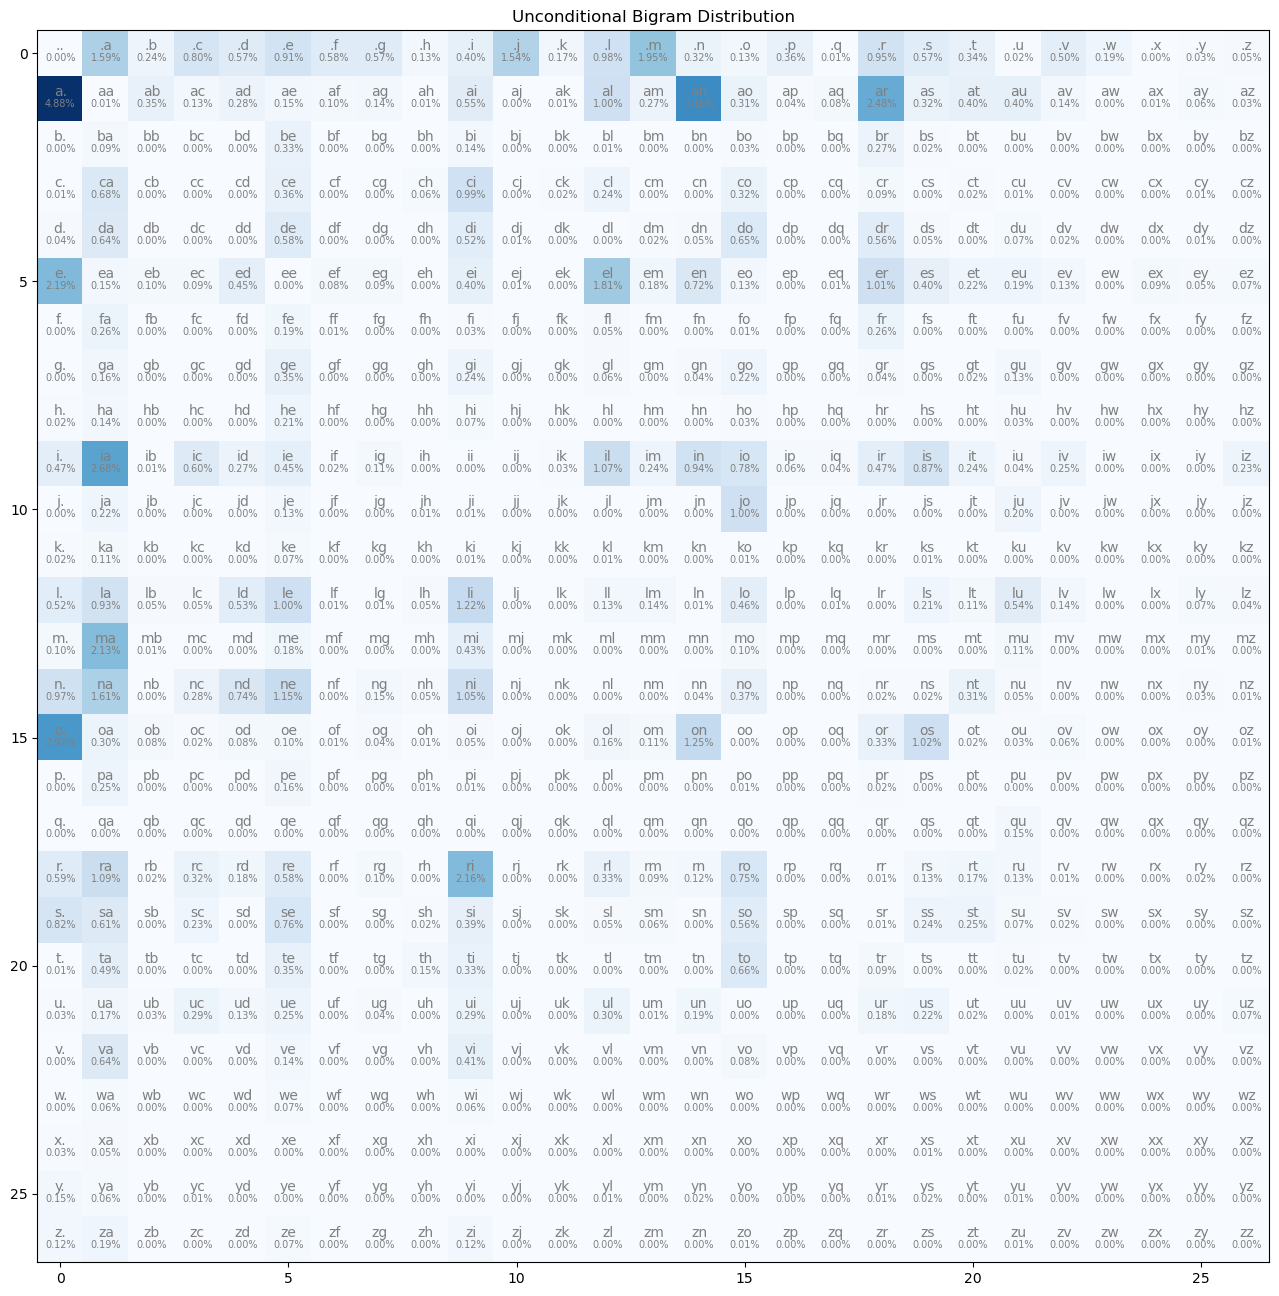

In [8]:
# Plot the unconditional bigram distribution
fig, ax = plt.subplots(figsize=(16, 16))

counts_norm = counts / counts.sum()
ax.imshow(counts_norm, cmap="Blues")

for i in range(n_chars + 1):
    for j in range(n_chars + 1):
        bigram = i_to_c[i] + i_to_c[j]
        ax.text(j, i, bigram, ha="center", va="bottom", color="gray")
        ax.text(
            x=j,
            y=i,
            s=f"{100 * counts_norm[i, j].item():.2f}%",
            ha="center",
            va="top",
            color="gray",
            size=7,
        )

ax.set_title("Unconditional Bigram Distribution");

In [9]:
uniform_probs = torch.ones_like(counts, dtype=torch.float32)
uniform_probs /= uniform_probs.sum(dim=1, keepdim=True)

bigram_probs = counts / counts.sum(dim=1, keepdim=True)

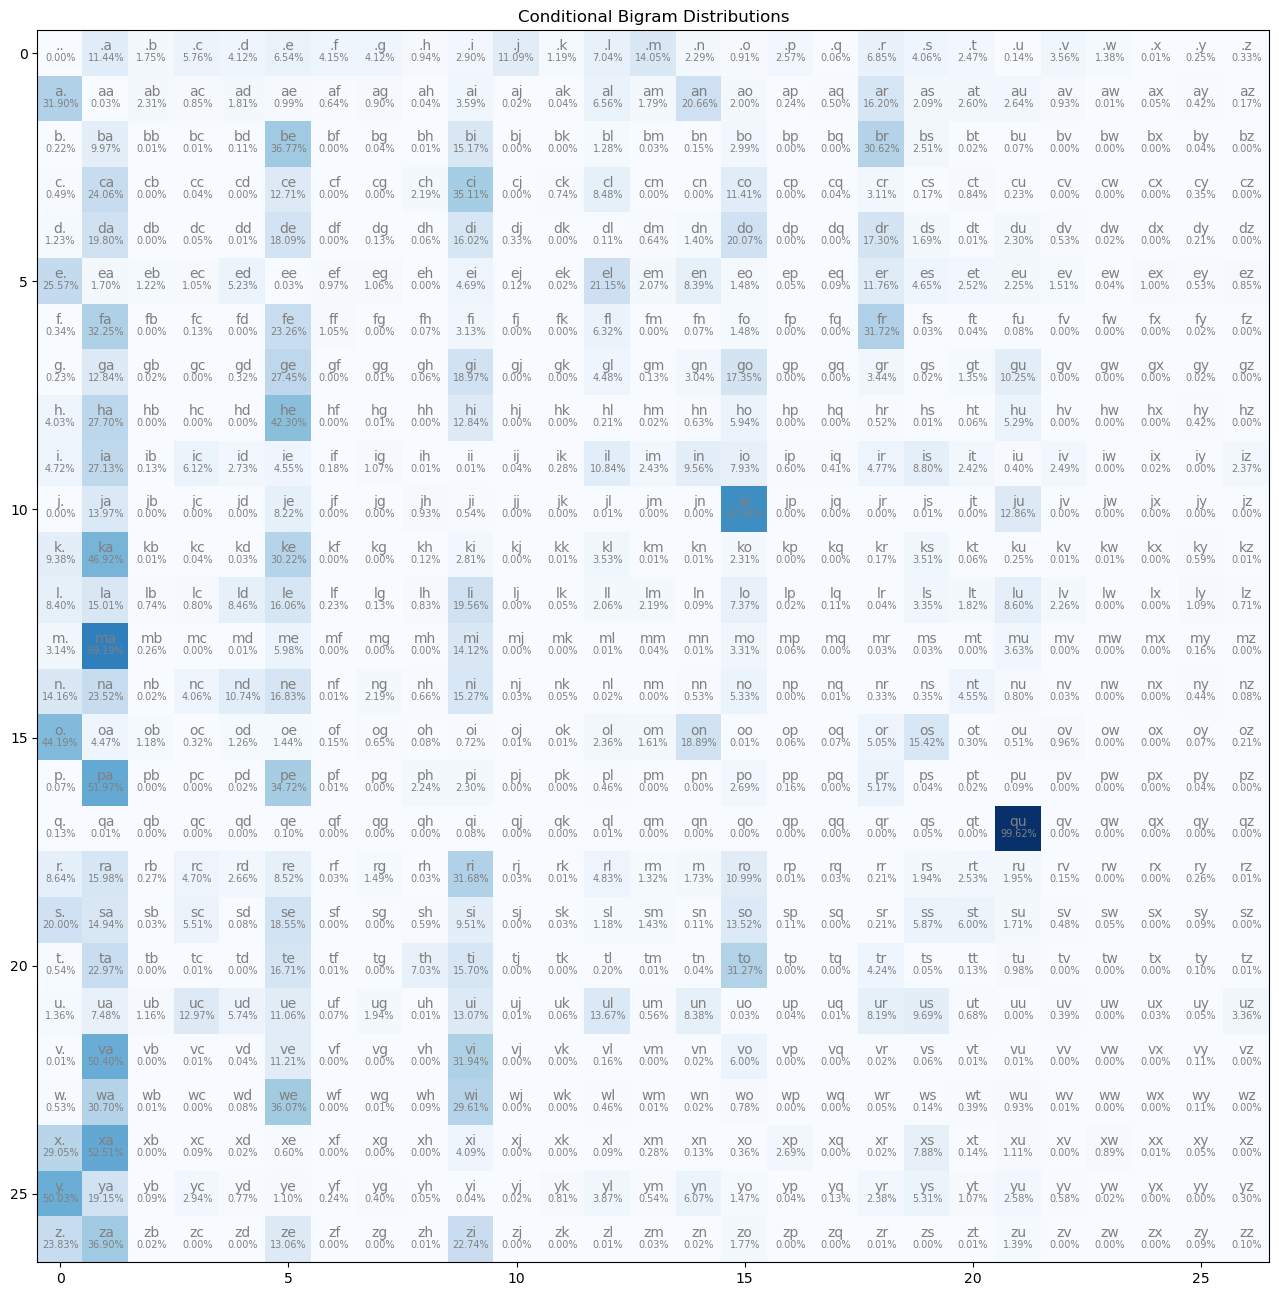

In [10]:
# Plot the conditional bigram distributions, each row represents a distribution
fig, ax = plt.subplots(figsize=(16, 16))

ax.imshow(bigram_probs, cmap="Blues")

for i in range(n_chars + 1):

    for j in range(n_chars + 1):

        bigram = i_to_c[i] + i_to_c[j]

        ax.text(j, i, bigram, ha="center", va="bottom", color="gray")

        ax.text(
            x=j,
            y=i,
            s=f"{100 * bigram_probs[i, j].item():.2f}%",
            ha="center",
            va="top",
            color="gray",
            size=7,
        )

ax.set_title("Conditional Bigram Distributions");

In [11]:
g = torch.Generator().manual_seed(112358)

def sample_name(probs: torch.Tensor) -> str:
    i = torch.multinomial(probs[0], num_samples=1, generator=g).item()

    chars = []

    while True:
        c = i_to_c[i]

        if c == ".":
            break
        else:
            chars.append(c)
            i = torch.multinomial(probs[i], num_samples=1, generator=g).item()

    return "".join(chars)


print("Sampling using the computed bigram model:")
for _ in range(10):
    print(" - " + sample_name(bigram_probs))

print("\nSampling using a uniform bigram model:")
for _ in range(10):
    print(" - " + sample_name(torch.ones_like(uniform_probs)))

Sampling using the computed bigram model:
 - anarianefasaglerimanina
 - je
 - jo
 - rilivaniaicicrivara
 - mariailanatarirelevia
 - ncldma
 - aigiama
 - ysar
 - dica
 - raosoanionarabefrldo

Sampling using a uniform bigram model:
 - xorhm
 - r
 - acaqrrmirfkacovdmkfvcakeonvjgaemicjuqlvtqwelkrhczjokxamurgh
 - xzjdn
 - rfwllhrgddxo
 - dhbmiadejtorjnwkemsrmrpitaxjvnpblfnsjg
 - wktd
 - iuusuesbwkyiybkiythdpynhlqcnbgxubeoorfyft
 - vsospvovezmiiflncfhhiljqdqsfoqjwwficfiwmfi
 - zpktg


In [12]:
# Compute the negative log-likelihood for the entire dataset, using bigram probs
def compute_nll_for_dataset(
    probs: torch.Tensor,
    idxs: torch.Tensor,
    next_idxs: torch.Tensor,
    weights: torch.Tensor,
) -> float:
    assert idxs.shape == next_idxs.shape == weights.shape

    nll = -1 * (weights * torch.log(probs[idxs, next_idxs])).sum()

    return nll.item()


# Compute the negative log-likelihood for a given name, using bigram probs
def compute_nll_for_name(name: str, probs: torch.Tensor) -> float:
    name = "." + name + "."
    likelihoods = []

    for c, c_next in zip(name, name[1:]):
        i, i_next = c_to_i[c], c_to_i[c_next]
        likelihoods.append(probs[i, i_next].item())

    return float(-np.log(likelihoods).mean())

In [13]:
print("------------- Computed Bigram Model -------------")

bigram_nll = compute_nll_for_dataset(
    bigram_probs,
    idxs,
    next_idxs,
    weights,
)
print(f"\nNegative Log-Likelihood for the dataset: \n{bigram_nll:.3f}")

print("\nNegative log-likelihoods for some real names:")
for name in ["rafael", "gabriela", "joao", "maria", "qkja"]:
    nll = compute_nll_for_name(name, bigram_probs)
    print(f" * '{name}': {nll:.3f}")

------------- Computed Bigram Model -------------

Negative Log-Likelihood for the dataset: 
2.176

Negative log-likelihoods for some real names:
 * 'rafael': 2.763
 * 'gabriela': 2.113
 * 'joao': 2.098
 * 'maria': 1.291
 * 'qkja': 7.370


In [14]:
print("------------- Uniform Bigram Model -------------")

uniform_nll = compute_nll_for_dataset(
    uniform_probs,
    idxs,
    next_idxs,
    weights,
)
print(f"\nNegative Log-Likelihood for the dataset: \n{uniform_nll:.3f}")

print("\nNegative log-likelihoods for some real names:")
for name in ["rafael", "gabriela", "joao", "maria", "qkja"]:
    nll = compute_nll_for_name(name, uniform_probs)
    print(f" * '{name}': {nll:.3f}")

------------- Uniform Bigram Model -------------

Negative Log-Likelihood for the dataset: 
3.296

Negative log-likelihoods for some real names:
 * 'rafael': 3.296
 * 'gabriela': 3.296
 * 'joao': 3.296
 * 'maria': 3.296
 * 'qkja': 3.296


### Training a Neural Network to learn the Bigram Model

In [15]:
# Create one-hot encodings for the input and output
X = F.one_hot(idxs, num_classes=n_chars + 1).float()
y = F.one_hot(next_idxs, num_classes=n_chars + 1).float()

In [16]:
# Compute the negative log-likelihood for the entire dataset, using the neural network weights
def nn_compute_nll_for_dataset(
    X: torch.Tensor,
    W: torch.Tensor,
    next_idxs: torch.Tensor,
    weights: torch.Tensor,
) -> float:
    assert X.shape[0] == len(next_idxs) == len(weights)

    # Forward pass
    logits = X @ W
    nn_counts = logits.exp()
    nn_probs = nn_counts / nn_counts.sum(dim=1, keepdim=True)

    rows = torch.arange(len(next_idxs))
    target_probs = nn_probs[rows, next_idxs]

    nll = -1 * (weights * torch.log(target_probs)).sum()

    return nll

# Compute the negative log-likelihood for a given name, using the neural network weights
def nn_compute_nll_for_name(name: str, W: torch.Tensor) -> float:
    name = "." + name + "."

    idxs = torch.tensor([c_to_i[c] for c in name[:-1]])
    next_idxs = torch.tensor([c_to_i[c] for c in name[1:]])

    # one-hot encoding of the input
    X = F.one_hot(idxs, num_classes=n_chars + 1).float()

    # Forward pass
    logits = X @ W
    counts = logits.exp()
    nn_probs = counts / counts.sum(dim=1, keepdim=True)

    # Get the probabilities for the actual next characters
    rows = torch.arange(len(next_idxs))
    target_probs = nn_probs[rows, next_idxs]

    nll = -1 * torch.log(target_probs).mean()

    return nll.item()

In [17]:
print("------------- Untrained Neural Network with Zero Weights -------------")

W = torch.zeros((n_chars + 1, n_chars + 1))
zero_nn_nll = nn_compute_nll_for_dataset(X, W, next_idxs, weights)

print(f"\nNegative Log-Likelihood for the dataset: \n{zero_nn_nll.item():.3f}")

print("\nNegative log-likelihoods for some real names:")
for name in ["rafael", "gabriela", "joao", "maria", "qkja"]:
    nll = nn_compute_nll_for_name(name, W)
    print(f" * '{name}': {nll:.3f}")

------------- Untrained Neural Network with Zero Weights -------------

Negative Log-Likelihood for the dataset: 
3.296

Negative log-likelihoods for some real names:
 * 'rafael': 3.296
 * 'gabriela': 3.296
 * 'joao': 3.296
 * 'maria': 3.296
 * 'qkja': 3.296


In [18]:
print("------------- Untrained Neural Network with Normal Weights -------------")

g = torch.Generator().manual_seed(112358)
W = torch.randn((n_chars + 1, n_chars + 1), generator=g, requires_grad=True)

loss = nn_compute_nll_for_dataset(X, W, next_idxs, weights)
print(f"\nNegative Log-Likelihood for the dataset: \n{loss.item():.3f}")

print("\nNegative log-likelihoods for some real names:")
for name in ["rafael", "gabriela", "joao", "maria", "qkja"]:
    nll = nn_compute_nll_for_name(name, W)
    print(f" * '{name}': {nll:.3f}")

------------- Untrained Neural Network with Normal Weights -------------

Negative Log-Likelihood for the dataset: 
3.831

Negative log-likelihoods for some real names:
 * 'rafael': 3.657
 * 'gabriela': 3.917
 * 'joao': 3.868
 * 'maria': 3.839
 * 'qkja': 4.115


In [19]:
# Training the neural network using gradient descent
loss_values = [loss.item()]

for i in range(500 + 1):
    # Backpropagation
    W.grad = None
    loss.backward()

    # Weight update, using a learning rate of 50
    W.data += -50 * W.grad

    loss = nn_compute_nll_for_dataset(X, W, next_idxs, weights)
    loss_values.append(loss.item())

    if i % 20 == 0:
        print(f"{i=} | loss={loss.item():.3f}")

i=0 | loss=3.244
i=20 | loss=2.307
i=40 | loss=2.244
i=60 | loss=2.221
i=80 | loss=2.210
i=100 | loss=2.203
i=120 | loss=2.199
i=140 | loss=2.196
i=160 | loss=2.194
i=180 | loss=2.192
i=200 | loss=2.191
i=220 | loss=2.190
i=240 | loss=2.189
i=260 | loss=2.188
i=280 | loss=2.188
i=300 | loss=2.187
i=320 | loss=2.187
i=340 | loss=2.186
i=360 | loss=2.186
i=380 | loss=2.185
i=400 | loss=2.185
i=420 | loss=2.185
i=440 | loss=2.185
i=460 | loss=2.184
i=480 | loss=2.184
i=500 | loss=2.184


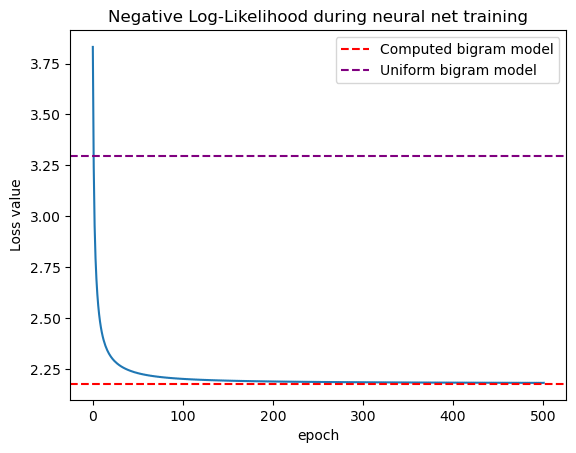

In [20]:
fig, ax = plt.subplots()

ax.plot(np.arange(len(loss_values)), loss_values)
ax.axhline(
    bigram_nll,
    color="red",
    linestyle="--",
    label="Computed bigram model",
)
ax.axhline(
    uniform_nll,
    color="purple",
    linestyle="--",
    label="Uniform bigram model",
)

ax.set_xlabel("epoch")
ax.set_ylabel("Loss value")
ax.set_title("Negative Log-Likelihood during neural net training")

ax.legend();

The Negative Log-Likelihood for the trained neural network using the bigrams as features and targets closely approaches that of the original bigram model, as the neural network effectively learns the probability distributions produced by the bigram model.

In [21]:
print("------------- Trained Neural Network -------------")

loss = nn_compute_nll_for_dataset(X, W, next_idxs, weights)
print(f"\nNegative Log-Likelihood for the dataset: \n{loss.item():.3f}")

print("\nNegative log-likelihoods for some real names:")
for name in ["rafael", "gabriela", "joao", "maria", "qkja"]:
    nll = nn_compute_nll_for_name(name, W)
    print(f" * '{name}': {nll:.3f}")

------------- Trained Neural Network -------------

Negative Log-Likelihood for the dataset: 
2.184

Negative log-likelihoods for some real names:
 * 'rafael': 2.750
 * 'gabriela': 2.148
 * 'joao': 2.088
 * 'maria': 1.326
 * 'qkja': 4.685


In [22]:
def nn_sample_name(W):
    i = 0
    name = []

    while True:
        p = W[i].exp() / W[i].exp().sum()
        i = torch.multinomial(p, num_samples=1, generator=g).item()

        if i == 0:
            break
        else:
            name.append(i_to_c[i])

    return "".join(name)

print("Sampling using the trained neural network:")
for _ in range(10):
    print(" - " + nn_sample_name(W))

print("\nSampling using a neural neural network with zero weights:")
for _ in range(10):
    print(" - " + nn_sample_name(torch.zeros_like(W)))

Sampling using the trained neural network:
 - e
 - ciceliari
 - ar
 - agrelicao
 - jenadisx
 - elundraza
 - rue
 - jonarindiqusela
 - ello
 - manderiladonamanaiave

Sampling using a neural neural network with zero weights:
 - wrrlhmlcebfakfmilqrxsnsoibdhzvqbbittsm
 - ekmm
 - mssndcgyodbznmxdgftwyqdscg
 - lqcjtdivvmqgtnzmbidojmzejjfrxegjsxtlqizrplrpjy
 - ymkusbh
 - fvcdvnnel
 - rxukd
 - ay
 - wqib
 - inucxxeqozkiifjsyyetncxr


#### Checking the Learned Probabilities

In [23]:
# The character '.' is used to represent the start and end of a name, with its index assigned as 0.
x0 = F.one_hot(torch.tensor([0]), num_classes=n_chars + 1).float()

# one-hot encoding of the 0 index:
x0

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [24]:
# Logits for the first character
logits_x0 = x0 @ W

logits_x0

tensor([[-4.0217,  2.0828,  0.2025,  1.3964,  1.0612,  1.5236,  1.0693,  1.0618,
         -0.4166,  0.7108,  2.0511, -0.1830,  1.5966,  2.2881,  0.4738, -0.4459,
          0.5889, -3.0802,  1.5690,  1.0473,  0.5481, -2.3136,  0.9160, -0.0358,
         -3.9227, -1.7655, -1.4589]], grad_fn=<MmBackward0>)

In [25]:
# Matrix multiplication when X is a single one-hot encoded vector is equivalent to indexing a row of W.
torch.isclose(logits_x0, W[0]).all().item()

True

In [26]:
# The probabilities for the first character, after applying the softmax function to the linear logits.
nn_probs_x0 = logits_x0.exp() / logits_x0.exp().sum()

nn_probs_x0.detach().numpy().round(decimals=3)

array([[0.   , 0.114, 0.017, 0.058, 0.041, 0.065, 0.042, 0.041, 0.009,
        0.029, 0.111, 0.012, 0.07 , 0.141, 0.023, 0.009, 0.026, 0.001,
        0.068, 0.041, 0.025, 0.001, 0.036, 0.014, 0.   , 0.002, 0.003]],
      dtype=float32)

In [27]:
# Checking the above softmax calculation matches with the PyTorch implementation.
torch.isclose(nn_probs_x0, torch.softmax(logits_x0, dim=1)).all().item()

True

In [28]:
def cosine_similarity(a: torch.Tensor, b: torch.Tensor) -> float:
    return (a.dot(b) / (a.norm() * b.norm())).item()

# Cosine similarity between the probability vectors for the first character, 
# with the left side computed using the neural network and 
# the right side using the bigram model.
cosine_similarity(nn_probs_x0.flatten(), bigram_probs[0])

0.9999991655349731

In [29]:
print("Cosine similarities between learned and bigram probability vectors, for each starting character:")

for i in range(n_chars + 1):
    x_enc = F.one_hot(torch.tensor([i]), num_classes=n_chars + 1).float()
    logits_i = x_enc @ W
    nn_probs_i = logits_i.exp() / logits_i.exp().sum()

    print(f" '{i_to_c[i]}': {cosine_similarity(nn_probs_i.flatten(), bigram_probs[i]):.3f}")

Cosine similarities between learned and bigram probability vectors, for each starting character:
 '.': 1.000
 'a': 0.968
 'b': 1.000
 'c': 1.000
 'd': 1.000
 'e': 1.000
 'f': 1.000
 'g': 1.000
 'h': 1.000
 'i': 1.000
 'j': 1.000
 'k': 0.997
 'l': 1.000
 'm': 1.000
 'n': 1.000
 'o': 1.000
 'p': 0.999
 'q': 1.000
 'r': 1.000
 's': 1.000
 't': 1.000
 'u': 1.000
 'v': 1.000
 'w': 0.999
 'x': 0.993
 'y': 0.999
 'z': 1.000


#### Visualizing the Learned Probabilities

In [30]:
# Cosine similarity between the flattened matrices of probabilities
all_idxs = torch.arange(n_chars + 1)
x_enc = F.one_hot(all_idxs, num_classes=n_chars + 1).float()
logits_all = x_enc @ W
nn_probs_all = logits_all.exp() / logits_all.exp().sum(dim=1, keepdim=True)

cosine_similarity(nn_probs_all.flatten(), bigram_probs.flatten())

0.9984612464904785

Very high cosine similarity between the two probability vectors shows again that the neural network has learned the bigram model.

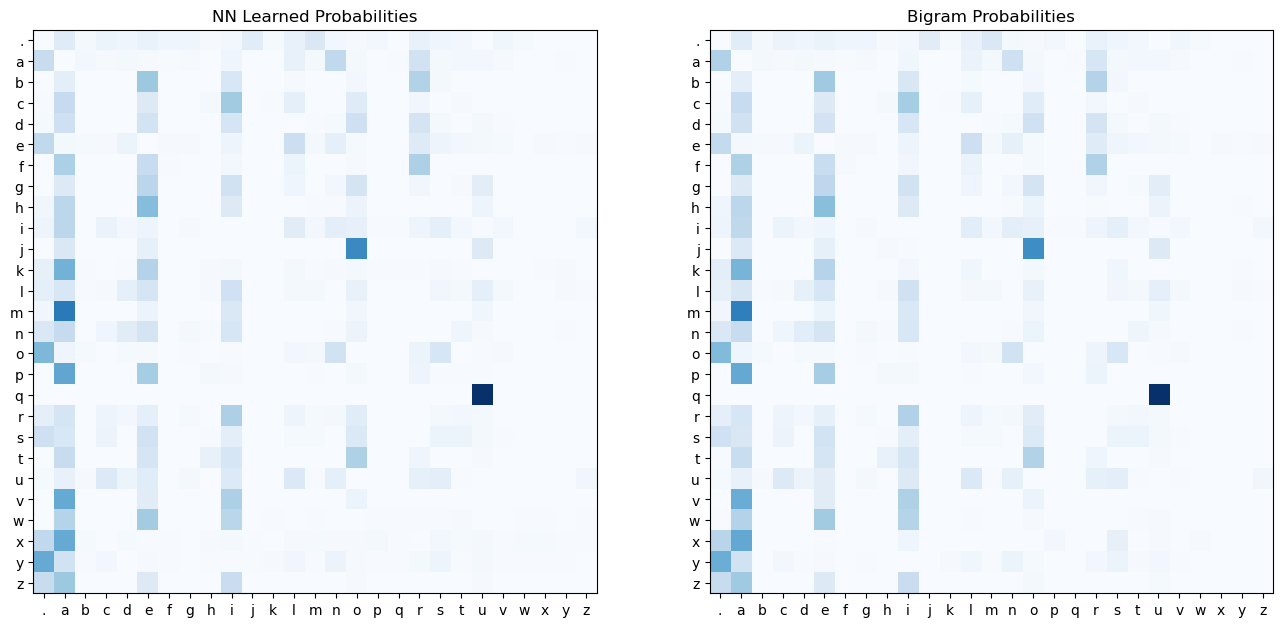

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

ax[0].imshow(nn_probs_all.detach().numpy(), cmap="Blues", norm="linear")
ax[0].set_title("NN Learned Probabilities")

ax[1].imshow(bigram_probs, cmap="Blues", norm="linear")
ax[1].set_title("Bigram Probabilities")

for i in [0, 1]:
    ax[i].set_xticks(range(n_chars + 1))
    ax[i].set_xticklabels(["."] + chars)
    ax[i].set_yticks(range(n_chars + 1))
    ax[i].set_yticklabels(["."] + chars)

As suggested by the high cosine similarity values, the probability distributions look very similar.

### Exploring the Effect of Regularization